# Table of Contents

- [I. Import libraries](#I)
- [II. Import data](#II)
  - [1. Download data](#II.1)
  - [2. Import data](#II.2)
- [III. Clean data](#III)
- [IV. Feature Engineering](#IV)
- [V. Regression models](#V)
  - [1. Linear Regression with statsmodel](#V.1.a)
  - [2. With sklearn and Cross Validation](#V.1.b)
  - [3. Regularization with LASSO and Ridge Regression](#V.1.c)
  - [4. Linear Regression with PCA transformation](#V.1.d)
  - [5. Regression with Log Transformation](#V.1.e)

# I. Import libraries <a name="I"></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os 
import warnings

from datetime import datetime, timedelta

from sklearn.model_selection import train_test_split, KFold, cross_validate, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.exponential_smoothing.ets import ETSModel

In [2]:
# Turn off warnings
warnings.filterwarnings("ignore")

# Set printed decimal limit
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set plot theme
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (16, 4)
custom_colors = ['#512d6d', '#e6a2b4', '#6b7d96', '#b3cde0']
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=custom_colors)

# II. Import data <a name="II"></a>

## 1. Download data  <a name="II.1"></a>

In [3]:
file_id = "1atOZX3YXmxx-_QebbTfndeC6U_DPTL2e" # ID of the file on Google Drive
file_name = 'Updated_data_2021&2022.csv'

%run download.ipynb

## 2. Import data <a name="II.2"></a>

In [4]:
# File path
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
file_path = os.path.join(parent_dir, 'Data',file_name)

df = pd.read_csv(file_path)
df.head()

,DATE_DIM,DAY_OF_WEEK,BET_ACCOUNT_NUM_HASH,AGE,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS
0,2021-01-01,Fri,13154,67.00,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288
1,2021-01-01,Fri,18379,54.00,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1
2,2021-01-01,Fri,559232,63.00,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5
3,2021-01-01,Fri,698904,69.00,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40
4,2021-01-01,Fri,762921,67.00,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5


# III. Clean data <a name="III"></a>

Based on our exploratory data analysis, we apply the similar steps to clean the data.

In [5]:
def clean_data(df):
    # DATE_DIM: datetime
    df['DATE_DIM'] = pd.to_datetime(df['DATE_DIM'], format='%Y-%m-%d')

    # BET_ACCOUNT_NUM_HASH: string
    df['BET_ACCOUNT_NUM_HASH'] = df['BET_ACCOUNT_NUM_HASH'].astype('O')

    # Impute AGE column
    df['AGE'].fillna(44, inplace=True)

    # More than zero
    df = df[df['TOTAL_TURNOVER'] > 0]
    
    # Drop redundant columns
    df.drop(['DAY_OF_WEEK', 'AGE'], axis=1, inplace=True)

    # Create RACING_TURNOVER column
    df['RACING_TURNOVER'] = df[['FOB_RACING_TURNOVER', 'PARI_RACING_TURNOVER']].sum(axis=1)
    
    return df.set_index('DATE_DIM')

df = clean_data(df)
df.head()

,BET_ACCOUNT_NUM_HASH,AGE_BAND,GENDER,TENURE_IN_DAYS,RESIDENTIAL_STATE,FOB_RACING_TURNOVER,FOB_SPORT_TURNOVER,PARI_RACING_TURNOVER,PARI_SPORT_TURNOVER,TOTAL_TURNOVER,DIVIDENDS_PAID,GROSS_MARGIN,TICKETS,RACING_TURNOVER
DATE_DIM,,,,,,,,,,,,,,
2021-01-01,13154,65+,M,11846,WA,37.00,NaN,1081.00,NaN,1118.00,443.55,271.25,288,1118.00
2021-01-01,18379,45-54,M,1884,WA,40.00,NaN,NaN,NaN,40.00,0.00,40.00,1,40.00
2021-01-01,559232,55-64,M,2866,WA,NaN,NaN,12.00,NaN,12.00,9.50,2.04,5,12.00
2021-01-01,698904,65+,M,2100,WA,NaN,NaN,1223.50,NaN,1223.50,267.91,245.12,40,1223.50
2021-01-01,762921,65+,M,4766,WA,NaN,NaN,17.50,NaN,17.50,0.00,3.50,5,17.50


# IV. Feature Engineering <a name="IV"></a>

We create a dataframe containing all demographic categorical factors: `AGE_BAND`, `GENDER`, `RESIDENTIAL_STATE`

In [6]:
# Create customer demographic info dataframe
def cus_aggregate(df):
    cus_df = df.groupby('BET_ACCOUNT_NUM_HASH').agg({'AGE_BAND':min, 'GENDER': min, 'RESIDENTIAL_STATE':min})
    return cus_df

cus_df = cus_aggregate(df)
cus_df.head()

,AGE_BAND,GENDER,RESIDENTIAL_STATE
BET_ACCOUNT_NUM_HASH,,,
13154,65+,M,WA
18379,45-54,M,WA
37251,18-24,U,WA
129273,18-24,U,WA
348318,25-34,U,WA


We extract behaviorial variables that could impact future spending:
- Frequency ([0-1])
- Racing spending ratio ([0-1])
- Dividends paid ratio (>0)
- Average turnover per day
- Average tickets purchased per day

We go back 1 week, 4 weeks and 12 weeks. Along with demographic data, here is the list of columns to be created and treated as independent variables.

Out predicted (dependent) variables will be the average turnover per day for the next 4 week.

| Column | Description |
|-----------------|-----------------|
| AGE_BAND | Customer’s age band as of Wager date | 
| GENDER | Customer’s gender (M, F, U) | 
| RESIDENTIAL_STATE | Residential state where the customer resides | 
| AVG_FREQ_12 | Betting frequency of the last 12 weeks [0-1] |
| RACING_RATIO_12 | Racing spending ratio of the last 12 weeks [0-1]|
| AVG_TURNOVER_12 | Average turnover per day for the last 12 weeks|
| DIVIDENDS_RATIO_12 |Dividends paid of the last 12 weeks|
| AVG_TICKETS_12 |Average tickets purchased per day for the last 12 weeks|
| AVG_FREQ_4 | Betting frequency of the last 4 weeks [0-1] |
| RACING_RATIO_4 | Racing spending ratio of the last 4 weeks [0-1]|
| AVG_TURNOVER_4 | Average turnover per day for the last 4 weeks|
| DIVIDENDS_RATIO_4 |Dividends paid of the last 4 weeks|
| AVG_TICKETS_4 |Average tickets purchased per day for the last 4 weeks|
| AVG_FREQ_1 | Betting frequency of the last week [0-1] |
| RACING_RATIO_1 | Racing spending ratio of the last week [0-1]|
| AVG_TURNOVER_1 | Average turnover per day for the last week|
| DIVIDENDS_RATIO_1 |Dividends paid of the last week|
| AVG_TICKETS_1 |Average tickets purchased per day for the last week|
| AVG_TURNOVER |Average turnover per day for the next 4 weeks|

In [7]:
def weekly_aggregate(df, date='2021-05-10', weeks=4):
    # Filtered period
    past_date = (datetime.strptime(date, '%Y-%m-%d') - timedelta(weeks=weeks)).strftime('%Y-%m-%d')
    
    # Aggregate
    agg_df = df[(df.index >= past_date ) & (df.index < date)].groupby('BET_ACCOUNT_NUM_HASH').agg({
        'BET_ACCOUNT_NUM_HASH': np.size,
        'TENURE_IN_DAYS' : max,
        'RACING_TURNOVER': sum,
        'TOTAL_TURNOVER' : sum,
        'DIVIDENDS_PAID' : sum,
        'TICKETS' : sum
    })
    
    # Create ratio columns
    agg_df['RACING_TURNOVER'] = agg_df['RACING_TURNOVER'] / agg_df['TOTAL_TURNOVER']
    agg_df['DIVIDENDS_PAID'] = agg_df['DIVIDENDS_PAID'] / agg_df['TOTAL_TURNOVER']

    # Create average columns
    agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] = agg_df[['BET_ACCOUNT_NUM_HASH', 'TOTAL_TURNOVER', 'TICKETS']] / (weeks*7)
    
    agg_df.columns = ['AVG_FREQ_' + str(weeks), 
                     'TENURE_IN_DAYS_' + str(weeks), 
                     'RACING_RATIO_' + str(weeks),
                     'AVG_TURNOVER_' + str(weeks),
                     'DIVIDENDS_RATIO_' + str(weeks),
                     'AVG_TICKETS_' + str(weeks)]
    
    return agg_df

def total_aggregate(df, date='2021-05-10'):
    # Prediction (4 weeks after the current week)
    future_date = (datetime.strptime(date, '%Y-%m-%d') + timedelta(weeks=4)).strftime('%Y-%m-%d')
    pred = df[ (df.index >= date ) & (df.index < future_date)].groupby('BET_ACCOUNT_NUM_HASH').TOTAL_TURNOVER.sum().to_frame() / 28
    pred.columns = ['AVG_TURNOVER']
    
    # Aggregate
    train_12 = weekly_aggregate(df,date=date, weeks=12)
    train_4 = weekly_aggregate(df,date=date, weeks=4)
    train_1 = weekly_aggregate(df,date=date, weeks=1)
    
    # Filter new customers
    train_12 = train_12[train_12['TENURE_IN_DAYS_12'] >= 84]
    
    # Join data
    train = pd.merge(train_12, train_4, left_index=True, right_index=True, how='left')
    train = pd.merge(train, train_1, left_index=True, right_index=True, how='left')
    train = pd.merge(train, pred, left_index=True, right_index=True, how='left')

    # Drop TENURE_IN_DAYS columns
    train.drop(['TENURE_IN_DAYS_12', 'TENURE_IN_DAYS_4', 'TENURE_IN_DAYS_1'], axis=1, inplace=True)
    
    # Fill na
    train.fillna(0, inplace=True)
    
    return train

In [8]:
# Choose 2021-05-10'
date='2021-05-10'
train = total_aggregate(df, date=date)

# Join with cus_df to get categorical data
train = pd.merge(train, cus_df, left_index=True, right_index=True, how='left')

# Preview
train.head()

,AVG_FREQ_12,RACING_RATIO_12,AVG_TURNOVER_12,DIVIDENDS_RATIO_12,AVG_TICKETS_12,AVG_FREQ_4,RACING_RATIO_4,AVG_TURNOVER_4,DIVIDENDS_RATIO_4,AVG_TICKETS_4,AVG_FREQ_1,RACING_RATIO_1,AVG_TURNOVER_1,DIVIDENDS_RATIO_1,AVG_TICKETS_1,AVG_TURNOVER,AGE_BAND,GENDER,RESIDENTIAL_STATE
BET_ACCOUNT_NUM_HASH,,,,,,,,,,,,,,,,,,,
13154,0.74,1.00,767.26,0.77,238.87,0.71,1.00,789.65,0.68,229.96,0.71,1.00,979.19,0.79,293.29,913.25,65+,M,WA
18379,0.19,1.00,34.29,0.94,0.71,0.11,1.00,18.93,1.31,0.61,0.14,1.00,14.29,3.15,0.29,28.71,45-54,M,WA
385032,0.01,1.00,0.04,0.00,0.02,0.04,1.00,0.11,0.00,0.07,0.00,0.00,0.00,0.00,0.00,0.57,25-34,U,WA
433164,0.36,1.00,53.97,0.87,102.27,0.46,1.00,96.17,0.98,185.00,0.71,1.00,22.50,0.15,44.43,26.38,35-44,U,WA
559232,0.38,1.00,9.61,0.94,2.62,0.50,0.99,15.39,1.14,4.18,0.00,0.00,0.00,0.00,0.00,17.79,55-64,M,WA


# V. Regression models <a name="V"></a>

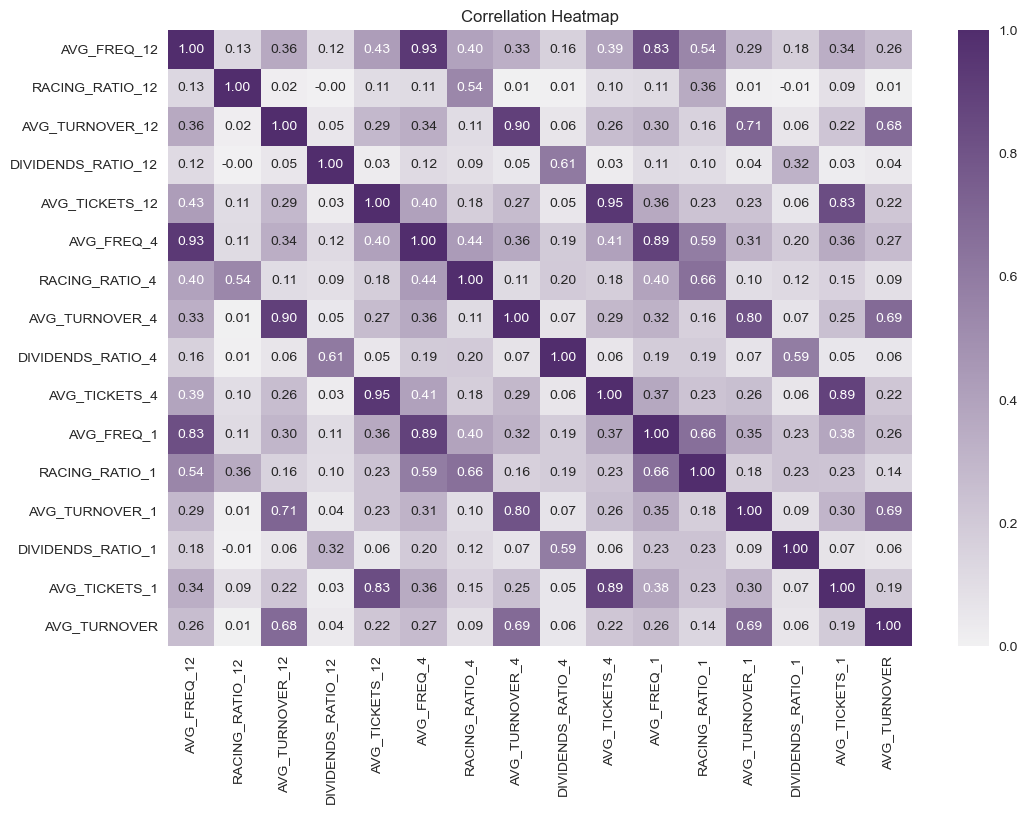

In [9]:
# Correlation matrix
corr_df = train.corr()

# Visualize
plt.figure(figsize=(12,8))

cmap = sns.light_palette("#512d6d", as_cmap=True)
sns.heatmap(corr_df, cmap=cmap, vmin=0, vmax=1 , annot=True, fmt=".2f")
plt.title("Correllation Heatmap")

plt.plot();

In [10]:
# Create X and y
X = train.drop('AVG_TURNOVER', axis=1)
y = train['AVG_TURNOVER']

# Evaluation dataframe
eva_df = pd.DataFrame(columns = ["Model", "MSE", "R2" ])

In [11]:
# Choose independent variables
cat_cols = ['AGE_BAND', 'GENDER', 'RESIDENTIAL_STATE']

num_cols = ['AVG_FREQ_12','RACING_RATIO_12','AVG_TURNOVER_12','DIVIDENDS_RATIO_12', 'AVG_TICKETS_12', 'AVG_FREQ_4', 'RACING_RATIO_4', 
            'AVG_TURNOVER_4','DIVIDENDS_RATIO_4','AVG_TICKETS_4','AVG_FREQ_1','RACING_RATIO_1','AVG_TURNOVER_1','DIVIDENDS_RATIO_1','AVG_TICKETS_1']

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

In [12]:
# Transform
X_trans = full_pipeline.fit_transform(X)
y = y.values.reshape(-1,1)

## 1. Linear Regression with statsmodel  <a name="V.1.a"></a>

In [13]:
# Add constant term
X_trans = sm.add_constant(X_trans)

# train and val set
X_train, X_val, y_train, y_val = train_test_split(X_trans, y, test_size=0.2, random_state=42)

# Fit model
model = sm.OLS(y_train, X_train) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.615
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     3327.
Date:                Tue, 18 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:33:27   Log-Likelihood:            -3.0132e+05
No. Observations:               50106   AIC:                         6.027e+05
Df Residuals:                   50081   BIC:                         6.029e+05
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.5494      2.521      0.615      0.539      -3.392       6.490
x1             3.5341      4.734      0.747      0.455      -5.744      12.813
x2             1.7155      4.489      0.382      0.702      -7.084      10.515
x3             0.4563      4.474      0.102      0.919      -8.314       9.226
x4             1.5038      4.477      0.336      0.737      -7.271      10.278
x5             2.7802      4.483      0.620      0.535      -6.006      11.567
x6            -0.1611      4.489     -0.036      0.971      -8.960       8.637
x7            -8.2794     28.631     -0.289      0.772     -64.397      47.838
x8             0.4634      1.290      0.359      0.719      -2.065       2.992
x9             3.5613      1.040      3.424      0.001       1.522       5.600
x10           -2.4753      1.060     -2.336      0.019      -4.552      -0.398
x11            3.5520      1.546      2.297      0.022       0.521       6.583
x12           -2.0025      1.409     -1.421      0.155      -4.764       0.759
x13          -18.6393      5.360     -3.478      0.001     -29.145      -8.134
x14           -0.7406      1.832     -0.404      0.686      -4.332       2.850
x15            0.3050      0.007     41.668      0.000       0.291       0.319
x16           -0.4793      0.717     -0.668      0.504      -1.885       0.926
x17            0.6850      0.082      8.349      0.000       0.524       0.846
x18           22.5120      6.347      3.547      0.000      10.072      34.952
x19            0.6774      1.556      0.435      0.663      -2.373       3.728
x20            0.2094      0.008     26.290      0.000       0.194       0.225
x21           -0.0179      0.617     -0.029      0.977      -1.227       1.191
x22           -0.0043      0.092     -0.047      0.963      -0.184       0.176
x23            3.6585      3.832      0.955      0.340      -3.852      11.169
x24            1.3990      1.518      0.922      0.357      -1.576       4.374
x25            0.3037      0.005     61.681      0.000       0.294       0.313
x26            0.4471      0.477      0.937      0.349      -0.488       1.382
x27           -0.4922      0.046    -10.608      0.000      -0.583      -0.401
==============================================================================
Omnibus:                   115098.847   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4692292082.130
Skew:                          21.606   Prob(JB):                         0.00
Kurtosis:                    1501.555   Cond. No.                     1.87e+16
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.07e-23. This might indicate

In [14]:
# Evaluation metrics
mse = results.mse_resid
R2 = results.rsquared

eva_df.append({"Model": "Linear Regression", "MSE" : mse, "R2" : R2},ignore_index=True)

,Model,MSE,R2
0,Linear Regression,9798.49,0.61


Positive points of the model:
- Good fit: R-squared and Adj. R-squared are relatively high
- No autoregression ( Durbin-Watson close to 2)

Problems with the model:
- Multicollinearity (high Cond. No.)
- Insignificant variables
- Heteroskedasticity
- Residuals significantly deviate from normality

Text(0.5, 1.0, 'Scatter plot: Real turnover vs. Residuals')

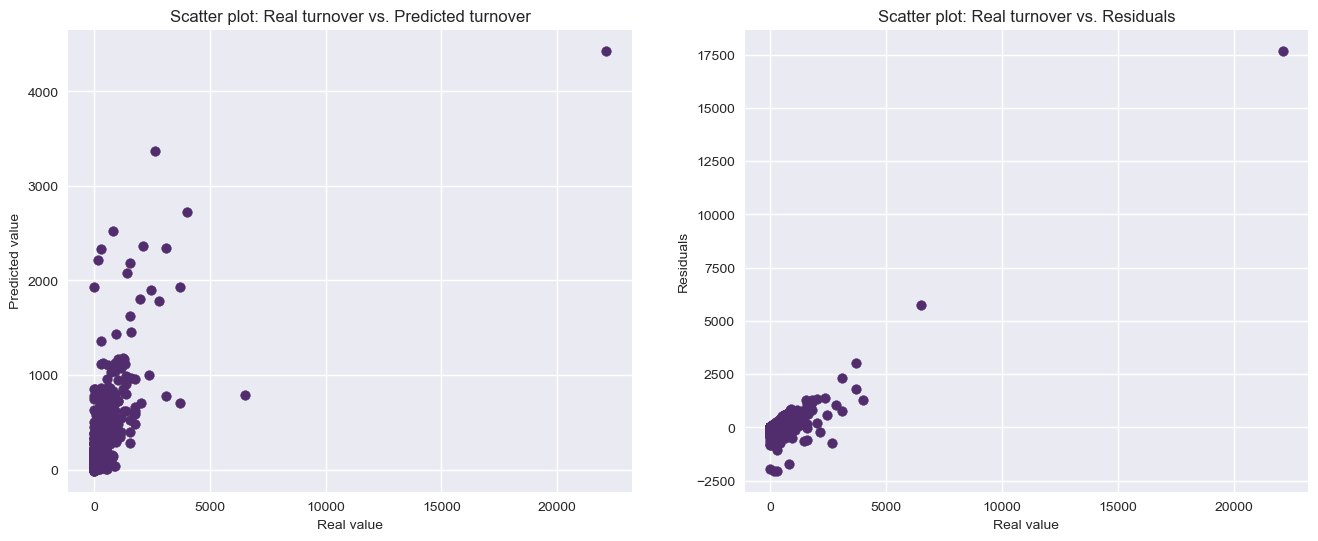

In [15]:
# Predict
y_pred = results.predict(X_val)
e = y_val.flatten() - y_pred

# Visualize
fig, axes = plt.subplots(1,2, figsize=(16,6))

axes[0].scatter(y_val, y_pred)
axes[0].set_xlabel("Real value")
axes[0].set_ylabel("Predicted value")
axes[0].set_title("Scatter plot: Real turnover vs. Predicted turnover") 

axes[1].scatter(y_val, e)
axes[1].set_xlabel("Real value")
axes[1].set_ylabel("Residuals")
axes[1].set_title("Scatter plot: Real turnover vs. Residuals") 

### Without categorical data

The results don't change much when removing categorical factors.

In [16]:
# Choose independent variables
cat_cols = []

num_cols = ['AVG_FREQ_12','RACING_RATIO_12','AVG_TURNOVER_12','DIVIDENDS_RATIO_12', 'AVG_TICKETS_12', 'AVG_FREQ_4', 'RACING_RATIO_4', 
            'AVG_TURNOVER_4','DIVIDENDS_RATIO_4','AVG_TICKETS_4','AVG_FREQ_1','RACING_RATIO_1','AVG_TURNOVER_1','DIVIDENDS_RATIO_1','AVG_TICKETS_1']

# Transform columns
one_hot_encoder = OneHotEncoder(sparse = False)

full_pipeline = ColumnTransformer([
    ("cat", one_hot_encoder, cat_cols),
    ("num", "passthrough", num_cols),
])

In [17]:
# Transform
X_trans = full_pipeline.fit_transform(X)

In [18]:
# Add constant term
X_trans = sm.add_constant(X_trans)

# train and val set
X_train, X_val, y_train, y_val = train_test_split(X_trans, y, test_size=0.2, random_state=42)

# Fit model
model = sm.OLS(y_train, X_train) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.614
Model:                            OLS   Adj. R-squared:                  0.614
Method:                 Least Squares   F-statistic:                     5316.
Date:                Tue, 18 Jul 2023   Prob (F-statistic):               0.00
Time:                        14:33:28   Log-Likelihood:            -3.0135e+05
No. Observations:               50106   AIC:                         6.027e+05
Df Residuals:                   50090   BIC:                         6.029e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.2824      1.451      1.573      0.116      -0.561       5.126
x1           -16.6180      5.330     -3.118      0.002     -27.065      -6.171
x2            -1.3447      1.814     -0.741      0.458      -4.900       2.210
x3             0.3062      0.007     41.840      0.000       0.292       0.321
x4            -0.4227      0.717     -0.590      0.555      -1.827       0.982
x5             0.6810      0.082      8.300      0.000       0.520       0.842
x6            21.6599      6.338      3.417      0.001       9.237      34.083
x7             0.8193      1.556      0.527      0.599      -2.230       3.869
x8             0.2097      0.008     26.323      0.000       0.194       0.225
x9            -0.0202      0.617     -0.033      0.974      -1.229       1.189
x10           -0.0061      0.092     -0.067      0.947      -0.186       0.174
x11            3.7210      3.833      0.971      0.332      -3.791      11.233
x12            1.5719      1.515      1.038      0.299      -1.397       4.541
x13            0.3041      0.005     61.741      0.000       0.294       0.314
x14            0.4612      0.477      0.967      0.334      -0.474       1.396
x15           -0.4914      0.046    -10.588      0.000      -0.582      -0.400
==============================================================================
Omnibus:                   115037.714   Durbin-Watson:                   1.999
Prob(Omnibus):                  0.000   Jarque-Bera (JB):       4682619532.201
Skew:                          21.577   Prob(JB):                         0.00
Kurtosis:                    1500.010   Cond. No.                     4.92e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.92e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [19]:
# Evaluation metrics
mse = results.mse_resid
R2 = results.rsquared

eva_df.append({"Model": "Linear Regression", "MSE" : mse, "R2" : R2},ignore_index=True)

,Model,MSE,R2
0,Linear Regression,9806.14,0.61


## 2. With sklearn and cross validation <a name="V.1.b"></a>

We use k-fold cross validation to eliminate selection bias. MSE above might be more positive because the validation set is within lower range.

In [20]:
# Transform
X_trans = full_pipeline.fit_transform(X)

In [21]:
# Fit model
lin_reg = LinearRegression(fit_intercept=True)

# K-fold cross validation with k=10
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(lin_reg, X_trans, y, cv=kfold, scoring = ['neg_mean_squared_error','r2'] )

In [22]:
# Adding metrics to the evaluation dataframe
mse = -scores['test_neg_mean_squared_error'].mean()
R2 = scores['test_r2'].mean()

eva_df = eva_df.append({"Model": "Linear Regression", "MSE" : mse, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,R2
0,Linear Regression,15524.48,0.56


## 3. Regularization with LASSO and Ridge Regression <a name="V.1.c"></a>

### LASSO Regression

LASSO regression, also known as L1 regularization, is a popular technique in statistical modeling and machine learning used for variable selection and regularization. It is an extension of linear regression that adds a penalty term to the ordinary least squares objective function. It helps eliminating insignificant variables.

In [23]:
# Create a model instance
lasso_reg = Lasso()

# Define the alpha values to be tested
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# GridSearchCV
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
lasso_grid = GridSearchCV(estimator=lasso_reg, param_grid={'alpha': alphas}, cv=kfold, return_train_score=True)

# Fit
lasso_grid.fit(X_trans,y)

# Alpha
alpha = lasso_grid.best_params_['alpha']
alpha

1000

In [24]:
# K-fold cross validation with k=10
lasso_reg = Lasso(alpha=alpha)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(lasso_reg, X_trans, y, cv=kfold, scoring = ['neg_mean_squared_error','r2'] )

In [25]:
# Adding metrics to the evaluation dataframe
mse = -scores['test_neg_mean_squared_error'].mean()
R2 = scores['test_r2'].mean()

eva_df = eva_df.append({"Model": "LASSO regression", "MSE" : mse, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,R2
0,Linear Regression,15524.48,0.56
1,LASSO regression,15552.24,0.56


### Ridge Regression

Ridge regression, also known as L2 regularization, is another widely used technique for linear regression that addresses the limitations of ordinary least squares. It is similar to lasso regression but uses a different penalty term. It shrinks down insignificant variables.

In [26]:
# Create a model instance
ridge_reg = Ridge()

# Define the alpha values to be tested
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

# GridSearchCV for alpha
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
ridge_grid = GridSearchCV(estimator=ridge_reg, param_grid={'alpha': alphas}, cv=kfold, return_train_score=True)

# Fit
ridge_grid.fit(X_trans,y)

# Best alpha
alpha = ridge_grid.best_params_['alpha']
alpha

1000

In [27]:
# K-fold cross validation with k=10
ridge_reg = Ridge(alpha=alpha)

kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(ridge_reg, X_trans, y, cv=kfold, scoring = ['neg_mean_squared_error','r2'] )

In [28]:
# Adding metrics to the evaluation dataframe
mse = -scores['test_neg_mean_squared_error'].mean()
R2 = scores['test_r2'].mean()

eva_df = eva_df.append({"Model": "Ridge regression", "MSE" : mse, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,R2
0,Linear Regression,15524.48,0.56
1,LASSO regression,15552.24,0.56
2,Ridge regression,15518.78,0.56


## 4. Linear Regression with PCA transformation <a name="V.1.d"></a>

Principal component analysis (PCA) is a popular algorithm to reduce data dimensions. It helps eradicating multicollinearity.

In [29]:
# Standard scaling before PCA
std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X_trans)

In [30]:
# PCA
pca = PCA()
pca.fit(X_scaled)

X_pca = pca.transform(X_scaled)

Text(0, 0.5, 'Explained Variance')

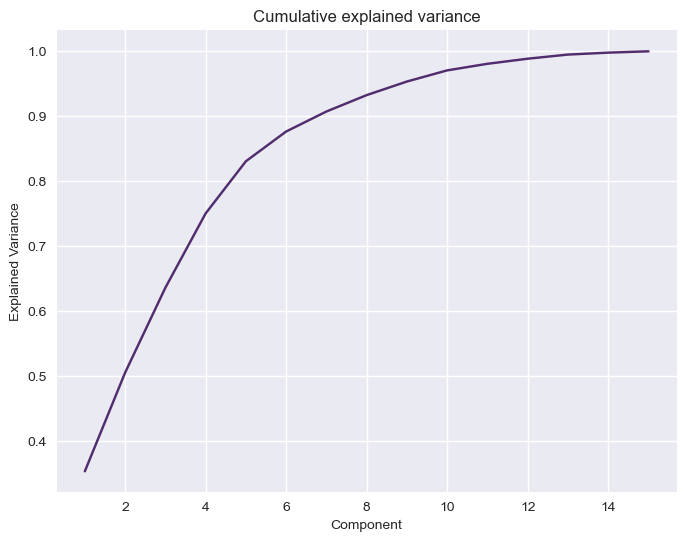

In [31]:
# Explained variance ratio
explained_var_ratio = pca.explained_variance_ratio_

# Visualize
plt.figure(figsize=(8,6))
plt.plot(range(1,16),np.cumsum(explained_var_ratio))
plt.title('Cumulative explained variance')
plt.xlabel('Component')
plt.ylabel('Explained Variance')

In [32]:
# We choose number of components to be 7 that explains 90% of the variance of the original data
X_pca = X_pca[:,:7]

In [33]:
# Fit model
lin_reg = LinearRegression(fit_intercept=True)

# K-fold cross validation with k=10
kfold = KFold(n_splits=10, shuffle=True, random_state=42)
scores = cross_validate(lin_reg, X_pca, y, cv=kfold, scoring = ['neg_mean_squared_error','r2'] )

In [34]:
# Adding metrics to the evaluation dataframe
mse = -scores['test_neg_mean_squared_error'].mean()
R2 = scores['test_r2'].mean()

eva_df = eva_df.append({"Model": "Linear Regression with PCA", "MSE" : mse, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,R2
0,Linear Regression,15524.48,0.56
1,LASSO regression,15552.24,0.56
2,Ridge regression,15518.78,0.56
3,Linear Regression with PCA,15351.31,0.57


## 5. Regression with Log Transformation <a name="V.1.e"></a>

We detect increasingly higher variance as the average turnover gets bigger. We choose `AVG_TURNOVER_12`, `AVG_TURNOVER_4`, `AVG_TURNOVER_1` to be the independent variables.

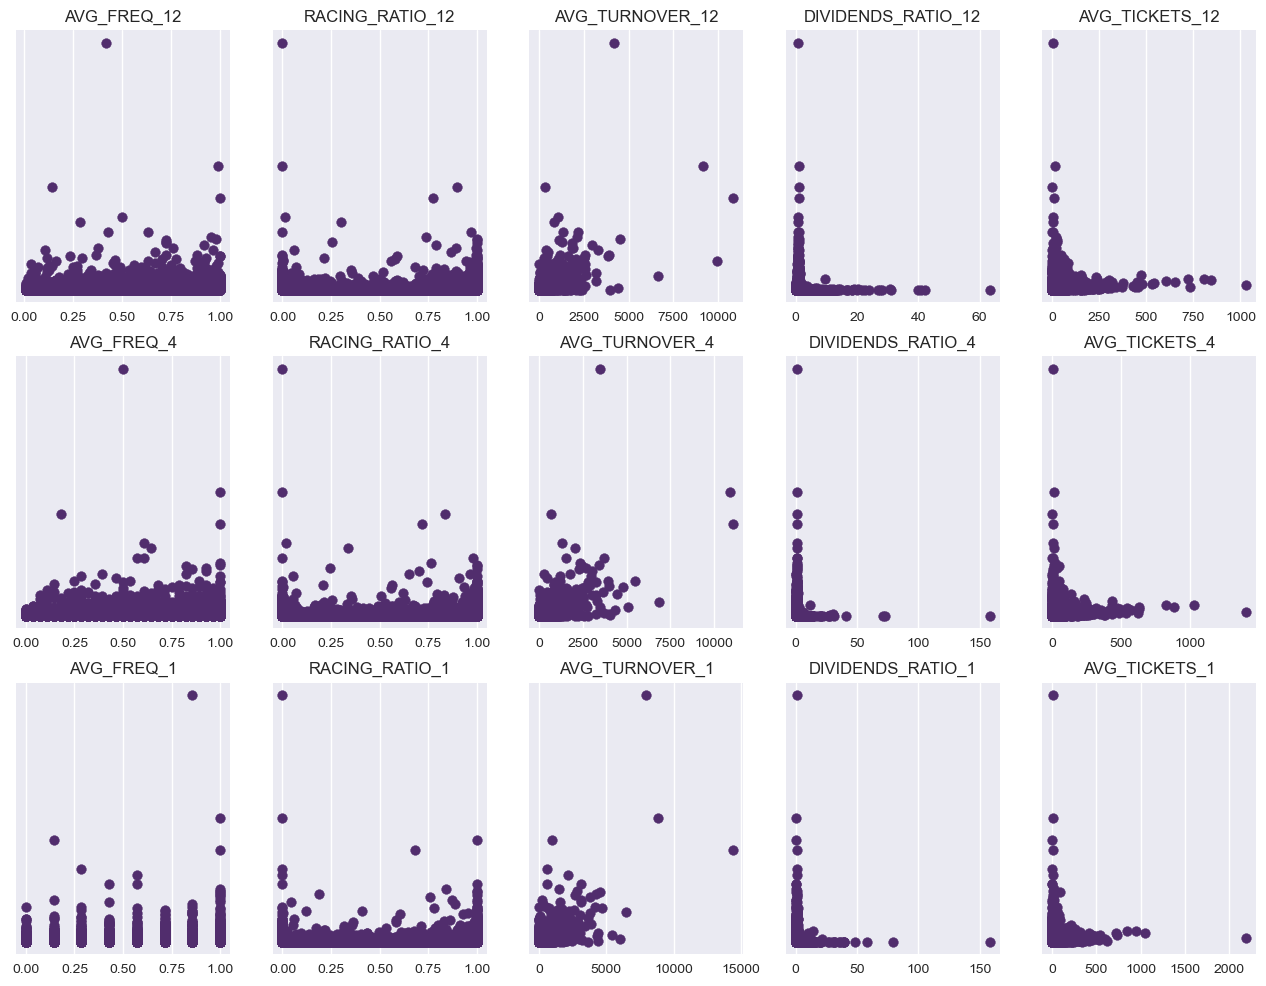

In [35]:
fig, axes = plt.subplots(3,5,figsize=(16,12))

for i in range(3):
    for j in range(5):
        axes[i,j].scatter(X.iloc[:,i*5 + j], y)
        axes[i,j].set_title(X.columns[i*5+ j]) 
        axes[i,j].set_yticks([])

In [36]:
X_log = np.log(X[['AVG_TURNOVER_12','AVG_TURNOVER_4','AVG_TURNOVER_1']]+1)
y_log = np.log(y+1)

In [37]:
model = sm.OLS(y_log, X_log) 
results = model.fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.877
Model:                            OLS   Adj. R-squared (uncentered):              0.877
Method:                 Least Squares   F-statistic:                          1.484e+05
Date:                Tue, 18 Jul 2023   Prob (F-statistic):                        0.00
Time:                        14:33:42   Log-Likelihood:                         -83995.
No. Observations:               62633   AIC:                                  1.680e+05
Df Residuals:                   62630   BIC:                                  1.680e+05
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
AVG_TURNOVER_12     0.3294      0.004     76.767      0.000       0.321       0.338
AVG_TURNOVER_4      0.3284      0.006     59.071      0.000       0.317       0.339
AVG_TURNOVER_1      0.2760      0.004     75.033      0.000       0.269       0.283
==============================================================================
Omnibus:                     5770.550   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            36227.524
Skew:                          -0.201   Prob(JB):                         0.00
Kurtosis:                       6.704   Cond. No.                         8.52
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
# Add the result to the evaluation model
y_pred = np.exp(results.predict(X_log))-1
mse = mean_squared_error(y.flatten(), y_pred)
R2 = r2_score(y.flatten(), y_pred)

eva_df = eva_df.append({"Model": "Log-Log Regression", "MSE" : mse, "R2" : R2},ignore_index=True)
eva_df

,Model,MSE,R2
0,Linear Regression,15524.48,0.56
1,LASSO regression,15552.24,0.56
2,Ridge regression,15518.78,0.56
3,Linear Regression with PCA,15351.31,0.57
4,Log-Log Regression,17487.73,0.47
